<table style="width: 100%; border-style: none;">
<tr style="border-style: none">
<td style="border-style: none; width: 1%; text-align: left;font-size: 16px">Institut f&uuml;r Theoretische Physik<br /> Universit&auml;t zu K&ouml;ln</td>
<td style="border-style: none; width: 1%; font-size: 16px">&nbsp;</td>
<td style="border-style: none; width: 1%; text-align: right; font-size: 16px">Prof. Dr. Simon Trebst<br />Jan Attig</td>
</tr>
</table>
<hr>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">Computerphysik</h1>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">Vorlesung &mdash; Programmiertechniken 9
</h1>
<hr>
<h3 style="font-weight:bold; text-align: center; margin: 0px; padding:0px; margin-bottom: 20px;">Sommersemester 2020</h3>

**Website:** [http://www.thp.uni-koeln.de/trebst/Lectures/2020-CompPhys.shtml](http://www.thp.uni-koeln.de/trebst/Lectures/2020-CompPhys.shtml)

**Themen dieses Notebooks:** Implementation des Ising Modells in Julia, Diskussion der Thermodynamik des Ising Modells

# Das Ising Modell

Das Ising Modell ist ein klassisches Spin-Modell welches sogenannte Ising Spins auf einem Quadratgitter beschreibt. Ising Spins können die Werte $\sigma_\alpha = \pm 1$ annehmen. Der komplette Hamiltonian des Modells ist

\begin{equation}
    \mathcal{H} = -J \sum_{\langle \alpha,\beta \rangle} \sigma_\alpha \sigma_\beta
\end{equation}

wobei die Summe über nächste Nachbarn auf dem Quadratgitter ausgeführt wird (siehe unten stehende Abbildung). $\alpha$ und $\beta$  bezeichnen dabei die Indices der verschiedenen Spins und können z.B. durch die Indices in den Gitterkoordinaten ausgedrückt werden: $\alpha = (i,j)$.

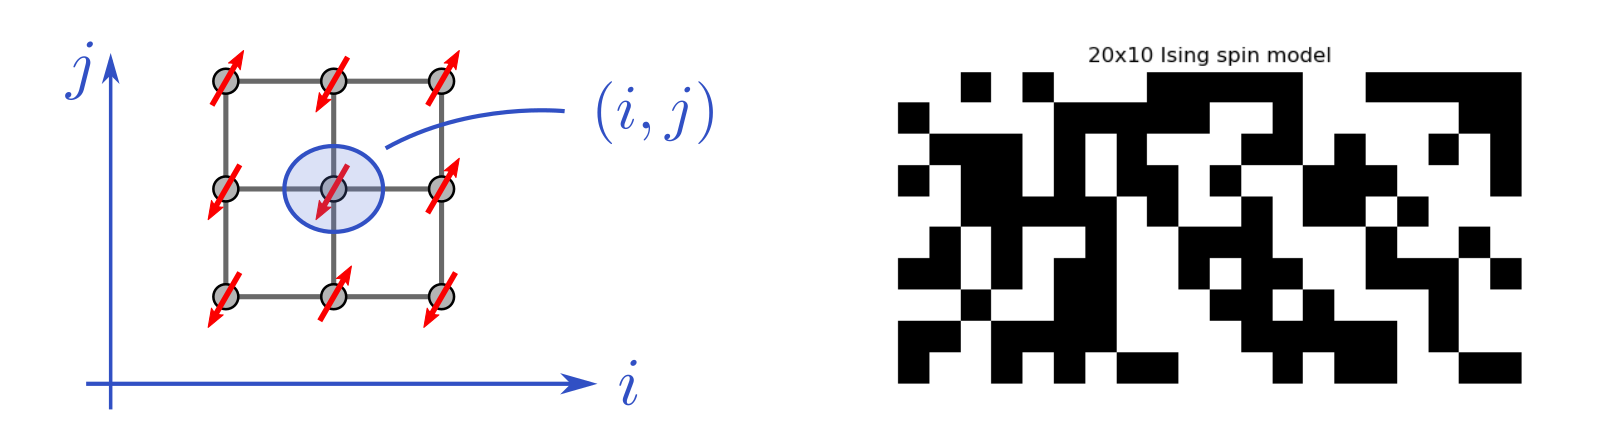

Die Implementation soll nach folgendem Schema ablaufen:

1. Zuerst werden Funktionen implementiert, die Ising Spins erzeugen und plotten. Damit wird im Programm die Möglichkeit geschaffen, Konfigurationen von Spins zu erzeugen und zu untersuchen.
2. Auf die bestehenden Konfigurationen wird eine Energie nach oben stehendem Hamiltonian definiert. Dafür ist die Summe über Nachbarn eines Spins (i,j) essentiell. Hier wollen wir periodische Rnadbedingungen verwenden.
3. Mit Hilfe der Energie lässt sich das Metropolis-Update als Funktion darstellen. Damit ist es möglich Markov-Ketten zu generieren.
4. Als letzter Schritt folgt die Diskussion thermodynamischer Observablen

# 1. Ising spins erzeugen und darstellen

### 1.1. Einen einzelnen Ising Spin erzeugen

In [1]:
function get_Ising_spin()
    # Pruefe ob Zufallszahl zwischen 0 und 1 groesser als 0.5
    if rand() > 0.5
        return +1
    else
        return -1
    end
end

get_Ising_spin (generic function with 1 method)

### 1.2. Ein Quadratgitter der Größe $L_x \times L_y$ mit Ising Spins erzeugen

In [2]:
function get_Ising_spins(Lx, Ly)
    # neues Array fuer die Ising Spins
    spins = zeros(Int64, Lx, Ly)
    # Alle Spins im Array auf zufaeelige Spins setzen
    for i in 1:Lx
    for j in 1:Ly
        spins[i,j] = get_Ising_spin()
    end
    end
    # Spins zurueckgeben
    return spins
end

get_Ising_spins (generic function with 1 method)

### 1.3. Ising Spins darstellen

In [3]:
# Importieren von PyPlot
using PyPlot
pygui(false)

function plot_Ising_spins(spins)
    # neue Figur anlegen
    figure()    
    # Die Spins plotten mittels imshow (in Schwarz-Weiss)
    imshow(spins', cmap="gray", origin="lower", interpolation="None")
    # keine Axenbeschriftung
    axis("off")
end

plot_Ising_spins (generic function with 1 method)

# 2. Nachbarschaft und Energie einer Konfiguration

Man kann die Gesamtenergie aller Spins in eine Summe der Energien einzelner Spins umschreiben, indem

\begin{align*}
    \mathcal{H} &= -J \sum_{\langle \alpha,\beta \rangle} \sigma_\alpha \sigma_\beta \\
        &=  -\frac{J}{2} \sum_{\alpha} \sigma_\alpha \sum_{\beta \in NN(\alpha)} \sigma_\beta  \\
        &=  \sum_{\alpha} \mathcal{H}_\alpha
\end{align*}

sodass $\mathcal{H}_\alpha = -\frac{J}{2} \sigma_\alpha \sum_{\beta \in NN(\alpha)} \sigma_\beta$. Dabei taucht die Summe aller Nachbarn mit Indices $\beta$ eines Spins an Stelle $\alpha$ auf.

### 2.1. Summe aller Nachbarn um einen Spin $(i,j)$

In [4]:
function get_NN_sum(spin_array, i,j)
    neighbor_sum = 0
    # (i,j) rechts
    if i < size(spin_array)[1]
        neighbor_sum += spin_array[i+1,j]
    else 
        neighbor_sum += spin_array[1, j]
    end
    
    # (i,j) links
    if i > 1
        neighbor_sum += spin_array[i-1,j]
    else
        neighbor_sum += spin_array[end,j]
    end
    
    # (i,j) oben
    if j < size(spin_array)[2]
        neighbor_sum += spin_array[i,j+1]
    else
        neighbor_sum += spin_array[i,1]
    end
    
    # (i,j) unten
    if j > 1
        neighbor_sum += spin_array[i,j-1]
    else
        neighbor_sum += spin_array[i,end]
    end
    
    return neighbor_sum
end

get_NN_sum (generic function with 1 method)

### 2.2. Energie aller Spins / Energie eines einzelnen Spins

In [5]:
function get_energy_of_spin(spin_array, J, i,j)
    return (-J/2) * spin_array[i,j] * get_NN_sum(spin_array, i,j)
end

get_energy_of_spin (generic function with 1 method)

In [6]:
function get_energy(spin_array, J)
    energy = 0.0
    for i in 1:size(spin_array)[1]
    for j in 1:size(spin_array)[2]
        energy += get_energy_of_spin(spin_array, J, i,j)
    end
    end
    return energy
end

get_energy (generic function with 1 method)

# 3. Metropolis Algorithmus

Hier benötigen wir zwei wesentliche Elemente:
1. das **Update** um von einer Konfiguration der Markov-Kette in eine Nächste überzugehen
2. die **Energiedifferenz** durch dieses Update

Wir wählen als Update das **Flippen eines einzelnen Spins $\sigma_\alpha$**. Damit ist die Energiedifferenz

\begin{align*}
    \Delta E &= \left(-J  \sum_{\langle \alpha,\beta \rangle} \sigma_\alpha' \sigma_\beta' \right) - \left(-J  \sum_{\langle \alpha,\beta \rangle} \sigma_\alpha \sigma_\beta\right) \\
        &= -J  \sum_{\beta \in NN(\alpha)} ((-\sigma_\alpha) \sigma_\beta - \sigma_\alpha \sigma_\beta) \\
        &= 2 J  \sum_{\beta \in NN(\alpha)} \sigma_\alpha \sigma_\beta \\
        &= 2 J \sigma_\alpha \sum_{\beta \in NN(\alpha)} \sigma_\beta
\end{align*}

welche wieder durch die Nachbarsummen ausgedrückt werden kann.

*Hinweis: Das Berechnen der **Gesamtenergie** ist für die Berechnung der Energiedifferenz nicht nötig!* 

### 3.1. Single Spin Flip update

In [7]:
function update_SSF!(spin_array, J, T)
    # Update vorschlagen
    i = rand(1:size(spin_array)[1])
    j = rand(1:size(spin_array)[2])
    # dE ausrechnen
    dE = 2*J*spin_array[i,j]*get_NN_sum(spin_array, i,j)
    # Akzeptieren Ja / Nein
    if rand() < exp(-dE / T)
        # JA
        spin_array[i,j] *= -1
    else
        # NEIN
    end
end

update_SSF! (generic function with 1 method)

### 3.2. Single Spin Flip sweep

In [128]:
function sweep_SSF!(spin_array, J, T)
    # Anzahl spins an Update vorschlagen
    for u in 1:size(spin_array)[1]*size(spin_array)[2] # just 1 possible flip per update
        update_SSF!(spin_array, J, T)
    end
end

sweep_SSF! (generic function with 1 method)

# 4. Zusammenfügen und Test

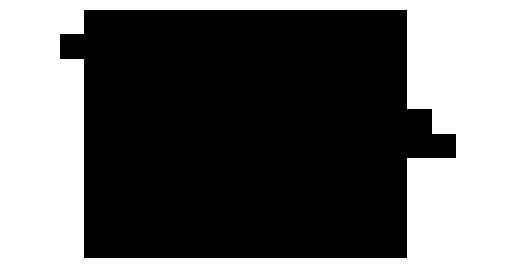

Energie pro Spin: -1.74


In [131]:
J = +1
T = 1

spins = get_Ising_spins(20, 10)

for i in 1:1000
    sweep_SSF!(spins, J, T)
end

plot_Ising_spins(spins)
println("Energie pro Spin: ", get_energy(spins,J) / length(spins))

# Thermalisierung

Wie findet die Markov-Kette ihren Weg von einer anfänglichen Konfiguration zu einer Kette von Konfigurationen, die der Boltzmann-Verteilung folgen? 

### 1. Beispiel

Energie pro Spin vorher ist E=-0.010857142857142857
Energie pro Spin nachher ist E=

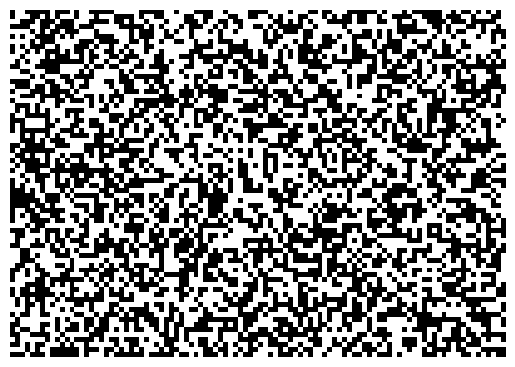

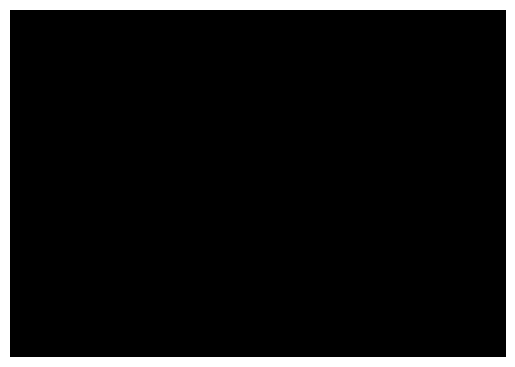

-2.0


In [94]:
# Kopplungsstaerke J definieren
J = +1
# Temperatur T definieren
T = 1

# Spins erzeugen
spins = get_Ising_spins(100, 70)
# Spins plotten
plot_Ising_spins(spins)
# Energie pro Spin ausgeben
println("Energie pro Spin vorher ist E=", get_energy(spins,J)/(length(spins)))

# Viele Updates ausfuehren
# dabei wird die Spin Konfiguration veraendert
for s in 1:1000
    sweep_SSF!(spins, J, T)
end

# resultierende Spin Konfiguration anschauen
plot_Ising_spins(spins)
# Energie pro Spin ausgeben
println("Energie pro Spin nachher ist E=", get_energy(spins,J)/(length(spins)))

### 2. Animation

In [32]:
# externes Fenster
pygui(true)

# Kopplungsstaerke J definieren
J = +1
# Temperatur T definieren
T = 0.1

# Spins erzeugen
spins = get_Ising_spins(100, 70)

# neue Figur zum Plotten
figure()
title("$(size(spins)[1])x$(size(spins)[2]) Ising spin model @ T=$(T) (J=$(J))")
data = imshow(spins', cmap="gray", interpolation="None", origin="lower")
axis("off")
pause(1)

# Sweeps durchfuehren und immer wieder updaten
for s in 1:1000
    sweep_SSF!(spins, J, T)
    data.set_array(spins')
    pause(0.01)
    if length(get_fignums()) == 0
        break
    end
end

# kein externes Fenster
pygui(false);

### 3. Energie vs. Sweep

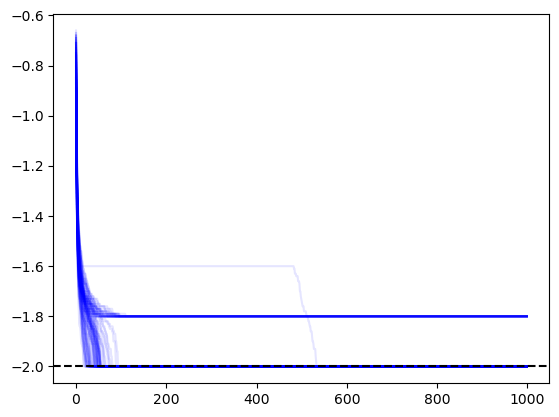

PyObject <matplotlib.lines.Line2D object at 0x7fecbfcc4460>

In [33]:
# Konstanten
L = 20
J = 1.0
T = 0.1
sweeps = 1000


# führe 100 Wiederholungen aus
for i in 1:100

    # neues array für energiewerte
    E_vals = zeros(sweeps)
    
    # neue anfängliche Spinkonfiguration
    spins  = get_Ising_spins(L,L)

    # sweeps durchfuehren und energie im jeweiligen sweep abspeichern
    for s in 1:sweeps
        sweep_SSF!(spins, J, T)
        E_vals[s] = get_energy(spins, J)/(length(spins))
    end

    # plotte die Energie der Konfiguration gegen den aktuellen Sweep in der Markov-Kette
    plot(E_vals, alpha=0.1, color="b")
    
end

# die zu erwartende Energie pro Spin im Grundzustand
axhline(-2, color="k", linestyle="--")

# Observable \#1: Energie vs. T

Die Gesamtenergie des System lässt sich messen als:

\begin{equation}
    \langle E \rangle = \frac{1}{M} \sum_{i=1}^{M} \mathcal{H}(\Sigma_i)
\end{equation}

wobei $\Sigma_i$ die Spinkonfigurationen in der Markov-Kette sind.

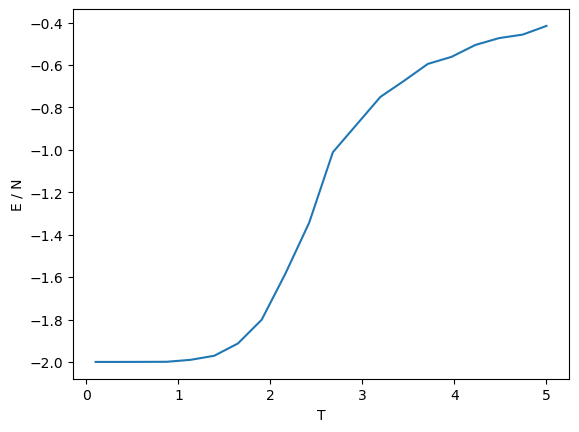

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fecbffa8700>

In [34]:
# Kopplungsstaerke J definieren
J = +1
# Systemgröße L definieren
L = 10
# Temperaturwerte T definieren
T_vals = range(0.1, 5.0, length=20)
# Anzahl der Sweeps für Thermalisierung und Messen
sweeps_TH = 10000
sweeps_ME = 1000

# Energieliste fuer Energiewerte
E_vals = []


# Alle Temperaturen T betrachten
for T in T_vals

    # Spins erzeugen
    spins = get_Ising_spins(L, L)
    
    # Energie Mittelwert initialisieren
    E_mean = 0.0

    # Thermalisierung
    for s in 1:sweeps_TH
        sweep_SSF!(spins, J, T)
    end
    # Messung
    for s in 1:sweeps_ME
        sweep_SSF!(spins, J, T)
        E_mean += get_energy(spins, J)
    end
    
    # Mittelwert berechnen
    E_mean = E_mean / (sweeps_ME)
    
    # mittelwert in liste pushen
    push!(E_vals, E_mean)

end


# Energie (pro Spin) gegen Temperatur plotten
xlabel("T")
ylabel("E / N")
plot(T_vals, E_vals ./ (length(spins)))

# Observable \#2: Magnetisierung vs. T

Die mittlere Magnetisierung des System lässt sich messen als:

\begin{equation}
    \langle M \rangle = \frac{1}{M} \sum_{i=1}^{M} M(\Sigma_i)
\end{equation}

wobei $\Sigma_i$ erneut die Spinkonfigurationen in der Markov-Kette sind und die Magnetisierung $M(\Sigma)$ definiert ist als Summe aller Spins der jeweiligen Konfiguration:

\begin{equation}
    M(\Sigma) = \sum_{\sigma_\alpha \in \Sigma} \sigma_\alpha
\end{equation}


In [35]:
function get_magnetization(spin_array)
    return sum(spin_array)
end

get_magnetization (generic function with 1 method)

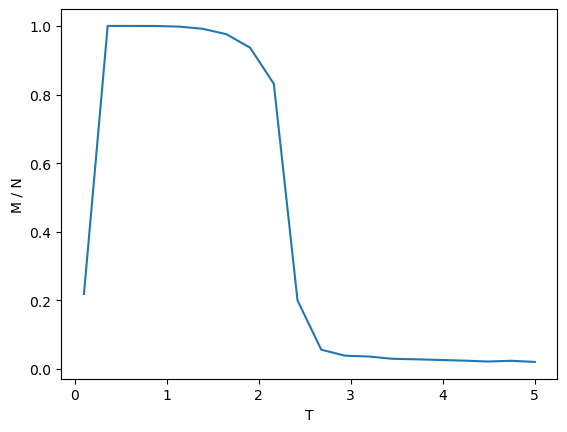

 35.248955 seconds (658.72 k allocations: 14.035 MiB, 1.48% gc time)


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7feccae75b20>

In [134]:
# Kopplungsstaerke J definieren
J = +1
# Systemgröße L definieren
L = 64 # 10
# Temperaturwerte T definieren
T_vals = range(0.1, 5.0, length=20)
# Anzahl der Sweeps für Thermalisierung und Messen
sweeps_TH = 10000
sweeps_ME = 1000

# Magnetisierungsliste fuer Magnetisierungswerte
M_vals = []


# Alle Temperaturen T betrachten
@time begin
for T in T_vals

    # Spins erzeugen
    spins = get_Ising_spins(L, L)
    
    # Magnetisierungs Mittelwert initialisieren
    M_mean = 0.0

    # Thermalisierung
    for s in 1:sweeps_TH
        sweep_SSF!(spins, J, T)
    end
    # Messung
    for s in 1:sweeps_ME
        sweep_SSF!(spins, J, T)
        M_mean += abs(get_magnetization(spins))
    end
    
    # Mittelwert berechnen
    M_mean = M_mean / sweeps_ME
    
    # mittelwert in liste pushen
    push!(M_vals, M_mean)

end
end


# Magnetisierung (pro Spin) gegen Temperatur plotten
xlabel("T")
ylabel("M / N")
plot(T_vals, M_vals ./ (length(spins)))

# Observable \#3: Spezifische Waerme

Die spezifische Wärmekapazität ist definiert als

\begin{equation}
    c_V = \frac{1}{N}\left.\frac{\partial \langle E \rangle}{\partial T}\right|_V
\end{equation}

Sie kann deswegen entweder als Ableitung der bereits berechneten Kurve E vs. T ermittelt werden, oder auf einem unabhängigen Weg über die Mittelwerte von $E$ und $E^2$ durch

\begin{equation}
    c_V = \frac{1}{T^2 N} \left(\langle E^2 \rangle - \langle E \rangle^2 \right)
\end{equation}

(Die Herleitung für diesen Ausdruck erfolgt über die Zustandssumme und wird Ihnen im Rahmen der statistischen Physik begegnen)

In [ ]:
# Kopplungsstaerke J definieren
J = +1
# Systemgröße L definieren
L = 20
# Temperaturwerte T definieren
T_vals = range(0.1, 5.0, length=20)
# Anzahl der Sweeps für Thermalisierung und Messen
sweeps_TH = 10000
sweeps_ME = 1000

# Liste fuer Spezifische Waerme
C_V_vals = []


# Alle Temperaturen T betrachten
for T in T_vals

    # Spins erzeugen
    spins = get_Ising_spins(L, L)
    
    # Energie Mittelwerte
    E_mean    = 0.0
    E_sq_mean = 0.0

    # Thermalisierung
    for s in 1:sweeps_TH
        sweep_SSF!(spins, J, T)
    end
    # Messung
    for s in 1:sweeps_ME
        sweep_SSF!(spins, J, T)
        energy  = get_energy(spins, J)
        E_mean    += energy
        E_sq_mean += energy*energy
    end
    
    # Mittelwerte berechnen
    E_mean    /= sweeps_ME
    E_sq_mean /= sweeps_ME
    
    # spez. waerme berechnen
    c_V = (E_sq_mean - E_mean*E_mean) / (T^2 * length(spins))
    
    # spez. waerme in liste pushen
    push!(C_V_vals, c_V)

end


# Spez. Waerme gegen Temperatur plotten
xlabel("T")
ylabel("c_V")
plot(T_vals, C_V_vals)

# Finite Size Scaling

### 1. Energie

In [ ]:
# Kopplungsstaerke J definieren
J = +1
# Systemgröße L definieren
L_vals = [2,4,6,8,10]
# Temperaturwerte T definieren
T_vals = range(0.1, 5.0, length=20)
# Anzahl der Sweeps für Thermalisierung und Messen
sweeps_TH = 10000
sweeps_ME = 10000


# alle systemgrößen L betrachten
for L in L_vals

    # Energieliste fuer Energiewerte
    E_vals = []

    # Alle Temperaturen T betrachten
    for T in T_vals

        # Spins erzeugen
        spins = get_Ising_spins(L, L)

        # Energie Mittelwert initialisieren
        E_mean = 0.0

        # Thermalisierung
        for s in 1:sweeps_TH
            sweep_SSF!(spins, J, T)
        end
        # Messung
        for s in 1:sweeps_ME
            sweep_SSF!(spins, J, T)
            E_mean += get_energy(spins, J)
        end

        # Mittelwert berechnen
        E_mean = E_mean / (sweeps_ME)

        # mittelwert in liste pushen
        push!(E_vals, E_mean)

    end
    
    # Energie (pro Spin) gegen Temperatur plotten
    plot(T_vals, E_vals ./ (length(spins)), label="L = $(L)")

end

# Plot formattieren
xlabel("T")
ylabel("E / N")
legend()

### 2. Magnetisierung

In [ ]:
# Kopplungsstaerke J definieren
J = +1
# Systemgröße L definieren
L_vals = [2,4,6,8,10]
# Temperaturwerte T definieren
T_vals = range(0.1, 5.0, length=20)
# Anzahl der Sweeps für Thermalisierung und Messen
sweeps_TH = 10000
sweeps_ME = 1000




# alle systemgrößen L betrachten
for L in L_vals

    # Magnetisierungsliste fuer Magnetisierungswerte
    M_vals = []

    # Alle Temperaturen T betrachten
    for T in T_vals

        # Spins erzeugen
        spins = get_Ising_spins(L, L)

        # Magnetisierungs Mittelwert initialisieren
        M_mean = 0.0

        # Thermalisierung
        for s in 1:sweeps_TH
            sweep_SSF!(spins, J, T)
        end
        # Messung
        for s in 1:sweeps_ME
            sweep_SSF!(spins, J, T)
            M_mean += abs(get_magnetization(spins))
        end

        # Mittelwert berechnen
        M_mean = M_mean / sweeps_ME

        # mittelwert in liste pushen
        push!(M_vals, M_mean)

    end

    # Magnetisierung (pro Spin) gegen Temperatur plotten
    plot(T_vals, M_vals ./ (length(spins)), label="L = $(L)")
end

# Plot formattieren
xlabel("T")
ylabel("M / N")
legend()

### 3. Spezifische Wärme

In [ ]:
# Kopplungsstaerke J definieren
J = +1
# Systemgröße L definieren
L_vals = [4,12,20]
# Temperaturwerte T definieren
T_vals = range(0.1, 5.0, length=20)
# Anzahl der Sweeps für Thermalisierung und Messen
sweeps_TH = 10000
sweeps_ME = 10000




# alle systemgrößen L betrachten
for L in L_vals

    # Liste fuer Spezifische Waerme
    C_V_vals = []

    # Alle Temperaturen T betrachten
    for T in T_vals

        # Spins erzeugen
        spins = get_Ising_spins(L, L)

        # Energie Mittelwerte
        E_mean    = 0.0
        E_sq_mean = 0.0

        # Thermalisierung
        for s in 1:sweeps_TH
            sweep_SSF!(spins, J, T)
        end
        # Messung
        for s in 1:sweeps_ME
            sweep_SSF!(spins, J, T)
            energy  = get_energy(spins, J)
            E_mean    += energy
            E_sq_mean += energy*energy
        end

        # Mittelwerte berechnen
        E_mean    /= sweeps_ME
        E_sq_mean /= sweeps_ME

        # spez. waerme berechnen
        c_V = (E_sq_mean - E_mean*E_mean) / (T^2 * length(spins))

        # spez. waerme in liste pushen
        push!(C_V_vals, c_V)

    end


    # Spez. Waerme gegen Temperatur plotten
    plot(T_vals, C_V_vals, label="L = $(L)")
end

# Plot formattieren
xlabel("T")
ylabel("c_V")
legend()

# Code beschleunigen

### 1. Neudefinition von Update und Sweep

In [ ]:
function update_SSF!(spin_array, J, T)
    # Update vorschlagen
    i = rand(1:size(spin_array)[1])
    j = rand(1:size(spin_array)[2])
    # dE ausrechnen
    dE = 2*J*spin_array[i,j]*get_NN_sum(spin_array, i,j)
    # Akzeptieren Ja / Nein
    if rand() < exp(-dE / T)
        # JA
        spin_array[i,j] *= -1
        # Aenderung der Energie zurueckgeben
        return dE
    else
        # NEIN
        # Aenderung der Energie zurueckgeben
        return 0.0
    end
end

function sweep_SSF!(spin_array, J, T)
    # Summiere Aenderung der Energie
    dE = 0.0
    # Anzahl spins an Update vorschlagen
    for u in 1:size(spin_array)[1]*size(spin_array)[2]
        dE += update_SSF!(spin_array, J, T)
    end
    # Aenderung der Energie zurueckgeben
    return dE
end

### 2. Testen

In [ ]:
# PyPlot mit externem Fenster
pygui(true)


# Kopplungsstaerke J definieren
J = +1
# Temperatur T definieren
T = 0.1

# Spins erzeugen
spins  = get_Ising_spins(100, 70)
energy = get_energy(spins, J)

# neue Figur zum Plotten
figure()
title("$(size(spins)[1])x$(size(spins)[2]) Ising spin model @ T=$(T) (J=$(J))")
data = imshow(spins'[end:-1:1,:], cmap="gray", interpolation="None", origin="lower")
axis("off")
pause(1)

# Sweeps durchfuehren und immer wieder updaten
for s in 1:1000
    energy += sweep_SSF!(spins, J, T)
    data.set_array(spins')
    pause(0.01)
    if length(get_fignums()) == 0
        break
    end
end

# kein externes Fenster mehr ab hier
pygui(false)

# Ausgabe der Energie
println("Energie pro Spin (korrekt):    E=", get_energy(spins,J)/(size(spins)[1]*size(spins)[2]))
println("Energie pro Spin (mitgeführt): E=", energy/(size(spins)[1]*size(spins)[2]))

### 3. Finite Size Scaling der Spezifischen Wärme

In [ ]:
# Kopplungsstaerke J definieren
J = +1
# Systemgröße L definieren
L_vals = [4,12,20]
# Temperaturwerte T definieren
T_vals = range(0.1, 5.0, length=20)
# Anzahl der Sweeps für Thermalisierung und Messen
sweeps_TH = 10000
sweeps_ME = 10000



# alle systemgrößen L betrachten
for L in L_vals

    # Liste fuer Spezifische Waerme
    C_V_vals = []

    # Alle Temperaturen T betrachten
    for T in T_vals

        # Spins erzeugen
        spins  = get_Ising_spins(L, L)
        energy = get_energy(spins, J)

        # Energie Mittelwerte
        E_mean    = 0.0
        E_sq_mean = 0.0

        # Thermalisierung
        for s in 1:sweeps_TH
            energy += sweep_SSF!(spins, J, T)
        end
        # Messung
        for s in 1:sweeps_ME
            energy += sweep_SSF!(spins, J, T)
            E_mean    += energy
            E_sq_mean += energy*energy
        end

        # Mittelwerte berechnen
        E_mean    /= sweeps_ME
        E_sq_mean /= sweeps_ME

        # spez. waerme berechnen
        c_V = (E_sq_mean - E_mean*E_mean) / (T^2 * length(spins))

        # spez. waerme in liste pushen
        push!(C_V_vals, c_V)

    end

    # Spez. Waerme gegen Temperatur plotten
    plot(T_vals, C_V_vals, label="L = $(L)")
end

# Plot formattieren
xlabel("T")
ylabel("c_V")
legend()